# Hierarchical Demand Structure Construction

This notebook focused on constructing the hierarchical structure
required for enterprise-scale demand forecasting.

The goal was to define and validate multiple aggregation levels
so that forecasts could later be reconciled across the hierarchy.


In [1]:
# Imported required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style for consistency
plt.style.use("ggplot")

pd.set_option("display.max_columns", 50)


In [2]:
# Reloaded raw datasets
sales = pd.read_csv("../data/raw/sales_train_validation.csv")
calendar = pd.read_csv("../data/raw/calendar.csv")

# Reconstructed long-format dataset
sales_long = sales.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name="day",
    value_name="demand"
)

sales_long = sales_long.merge(calendar, left_on="day", right_on="d", how="left")
sales_long.drop(columns=["d"], inplace=True)

# Verified data structure
sales_long.head()


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


## Why Hierarchical Forecasting?

In real-world organizations, demand forecasts are required
at multiple levels:

- Individual product (SKU)
- Store-level operations
- Regional planning
- Company-wide reporting

Forecasts must be:
- Accurate at the lowest level
- Consistent when aggregated

This required explicitly defining the hierarchy before modeling.


## Hierarchy Levels Defined

The following hierarchy was used:

Level 0: Total demand  
Level 1: State  
Level 2: Store  
Level 3: Category  
Level 4: SKU–Store (lowest level)


In [3]:
# Created unique identifiers for bottom-level time series
sales_long["sku_store"] = (
    sales_long["item_id"] + "_" + sales_long["store_id"]
)

# Verified uniqueness
sales_long["sku_store"].nunique()


30490

## Aggregating Demand at Each Hierarchy Level

Demand was aggregated at multiple levels to validate
hierarchical consistency and variability.


In [4]:
total_level = (
    sales_long
    .groupby("date")["demand"]
    .sum()
    .reset_index()
)


In [5]:
state_level = (
    sales_long
    .groupby(["state_id", "date"])["demand"]
    .sum()
    .reset_index()
)


In [7]:
store_level = (
    sales_long
    .groupby(["store_id", "date"])["demand"]
    .sum()
    .reset_index()
)


In [8]:
category_level = (
    sales_long
    .groupby(["cat_id", "date"])["demand"]
    .sum()
    .reset_index()
)


## Validating Hierarchical Consistency

Aggregated demand at lower levels should match
demand at higher levels when summed.


In [9]:
# Checked if store-level aggregation matched total-level demand
store_sum = store_level.groupby("date")["demand"].sum()
total_sum = total_level.set_index("date")["demand"]

(store_sum - total_sum).abs().max()


0

## Visual Comparison Across Hierarchy Levels

Demand variability and smoothness were compared
across aggregation levels.


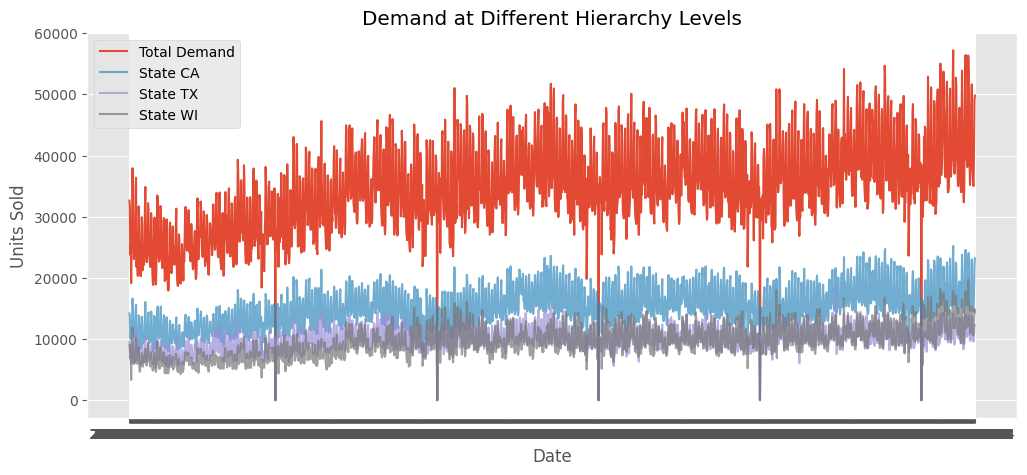

In [10]:
plt.figure(figsize=(12, 5))

plt.plot(total_level["date"], total_level["demand"], label="Total Demand")

for state in state_level["state_id"].unique()[:3]:
    subset = state_level[state_level["state_id"] == state]
    plt.plot(subset["date"], subset["demand"], alpha=0.7, label=f"State {state}")

plt.legend()
plt.title("Demand at Different Hierarchy Levels")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()


Insights:

- Higher-level demand was smoother and more predictable.
- Lower-level demand exhibited higher variance and sparsity.
- This justified training models at the lowest level
  and reconciling upward.


## Saving Hierarchy Metadata

Hierarchy mappings were saved to ensure consistent
model training and reconciliation in later stages.


In [11]:
hierarchy_mapping = sales_long[
    ["sku_store", "item_id", "store_id", "state_id", "cat_id"]
].drop_duplicates()

hierarchy_mapping.to_csv(
    "../data/processed/hierarchy_mapping.csv",
    index=False
)


## Summary

In this notebook:

- The demand hierarchy was explicitly defined.
- Multiple aggregation levels were constructed and validated.
- Differences in variability across levels were visualized.
- Hierarchy metadata was saved for downstream reconciliation.

This structure enabled consistent, enterprise-grade forecasting
in subsequent notebooks.
